In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [3]:
df = pd.read_excel("premiums_rest.xlsx")
df.head()

,Unnamed: 0,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,5,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [4]:
df.shape

(29904, 14)

In [5]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head(1)

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053


In [6]:
df.isna().sum()

unnamed:_0               0
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.isna().sum()

unnamed:_0               0
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [9]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [10]:
df.describe()

,unnamed:_0,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.000000
mean,25027.094091,43.396105,2.379910,23.364184,20892.303821
std,14432.632929,13.412657,1.431201,24.740339,6936.813440
min,0.000000,26.000000,-3.000000,1.000000,3625.000000
25%,12599.250000,34.000000,1.000000,7.000000,15697.250000
50%,25067.500000,42.000000,3.000000,17.000000,20489.000000
75%,37563.750000,52.000000,3.000000,32.000000,26360.000000
max,49999.000000,356.000000,5.000000,930.000000,43471.000000


In [11]:
df[df.number_of_dependants < 0]["number_of_dependants"].value_counts()

number_of_dependants
-1    30
-3    20
Name: count, dtype: int64

In [12]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

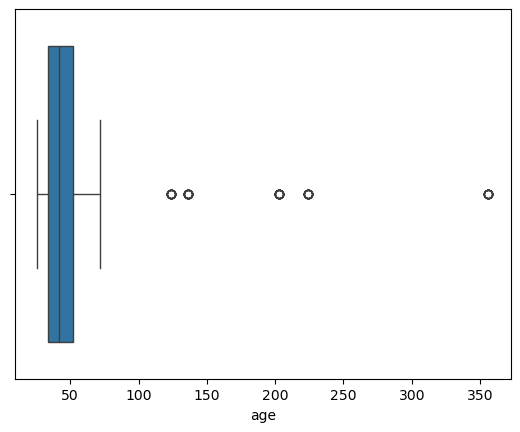

In [13]:
sns.boxplot(x=df['age'])
plt.show()

In [14]:
df1 = df[df.age<=100].copy()
df1.describe()

,unnamed:_0,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29828.000000,29828.000000,29828.000000,29828.000000,29828.000000
mean,25028.882091,43.095380,2.387790,23.371530,20901.900563
std,14431.843528,11.041991,1.420641,24.751262,6928.457636
min,0.000000,26.000000,0.000000,1.000000,6538.000000
25%,12599.750000,34.000000,1.000000,7.000000,15706.000000
50%,25068.500000,42.000000,3.000000,17.000000,20496.000000
75%,37564.500000,52.000000,3.000000,32.000000,26361.000000
max,49999.000000,72.000000,5.000000,930.000000,43471.000000


In [15]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [16]:
df1.income_lakhs.quantile([0.25, 0.75])

0.25     7.0
0.75    32.0
Name: income_lakhs, dtype: float64

In [17]:
get_iqr_bounds(df1.income_lakhs)

(-30.5, 69.5)

In [18]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

100.0

In [19]:
df2 = df1[df1.income_lakhs<=quantile_threshold].copy()

In [20]:
df2.describe()

,unnamed:_0,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,25030.357152,43.094896,2.387734,23.226343,20900.689223
std,14431.397026,11.042430,1.420644,22.455408,6928.192115
min,0.000000,26.000000,0.000000,1.000000,6538.000000
25%,12605.250000,34.000000,1.000000,7.000000,15705.250000
50%,25070.000000,42.000000,3.000000,17.000000,20495.500000
75%,37565.500000,52.000000,3.000000,32.000000,26360.000000
max,49999.000000,72.000000,5.000000,100.000000,43471.000000


In [21]:
numeric_columns = df1.select_dtypes(include=["float64", "int64"]).columns

IndexError: index 2 is out of bounds for axis 0 with size 2

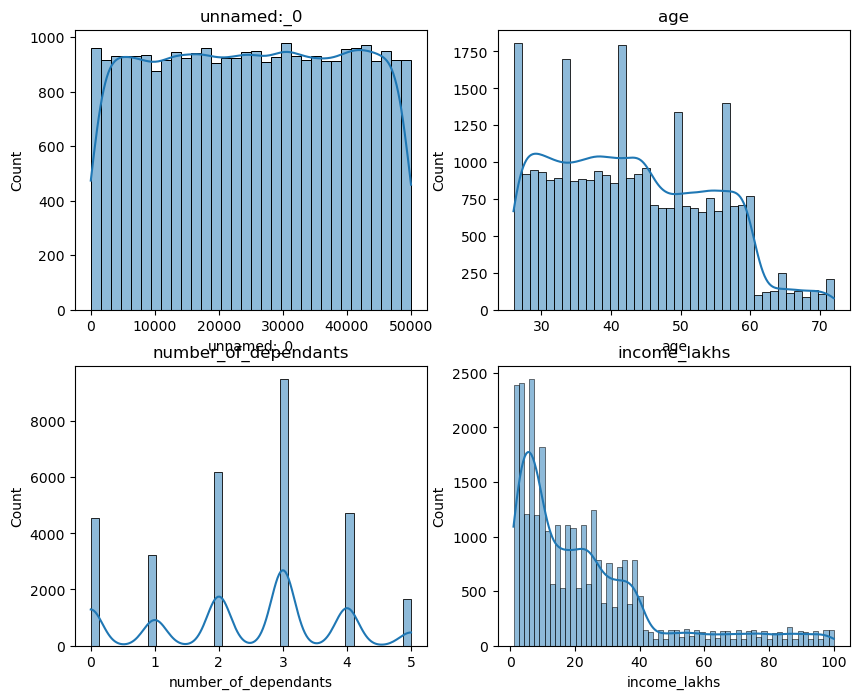

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Adjust the size as necessary

for i, column in enumerate(numeric_columns):
    ax = axs[i//2, i%2]  # Determines the position of the subplot in the grid
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

<Axes: xlabel='age', ylabel='annual_premium_amount'>

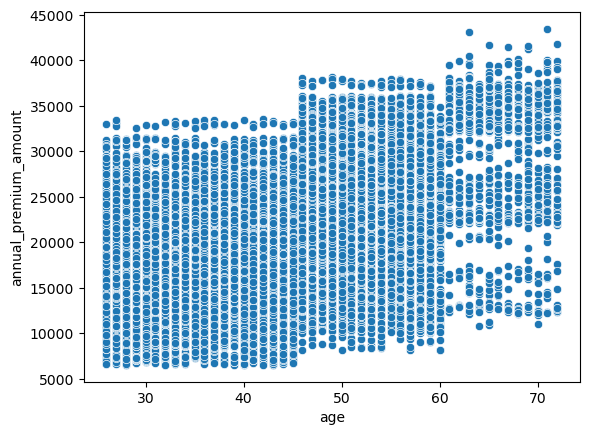

In [69]:
sns.scatterplot(df2, x='age', y='annual_premium_amount')

In [70]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [73]:
df2['smoking_status'].replace({
    'Smoking=0':'No Smoking',
    'Does Not Smoke':'No Smoking',
    'Not Smoking':'No Smoking'
},inplace=True)
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [75]:
pct_count = df2['gender'].value_counts(normalize=True)
pct_count

gender
Male      0.549125
Female    0.450875
Name: proportion, dtype: float64

<Axes: xlabel='gender'>

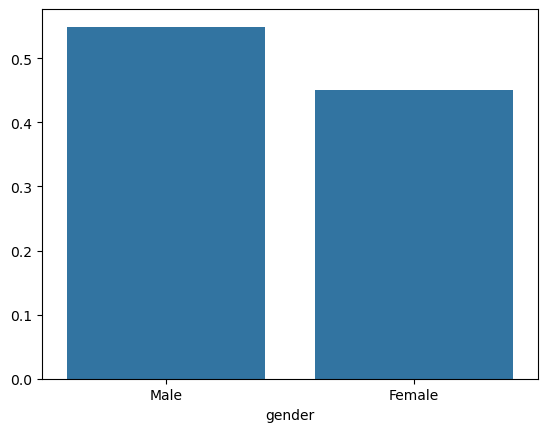

In [77]:
sns.barplot(x=pct_count.index, y=pct_count.values)

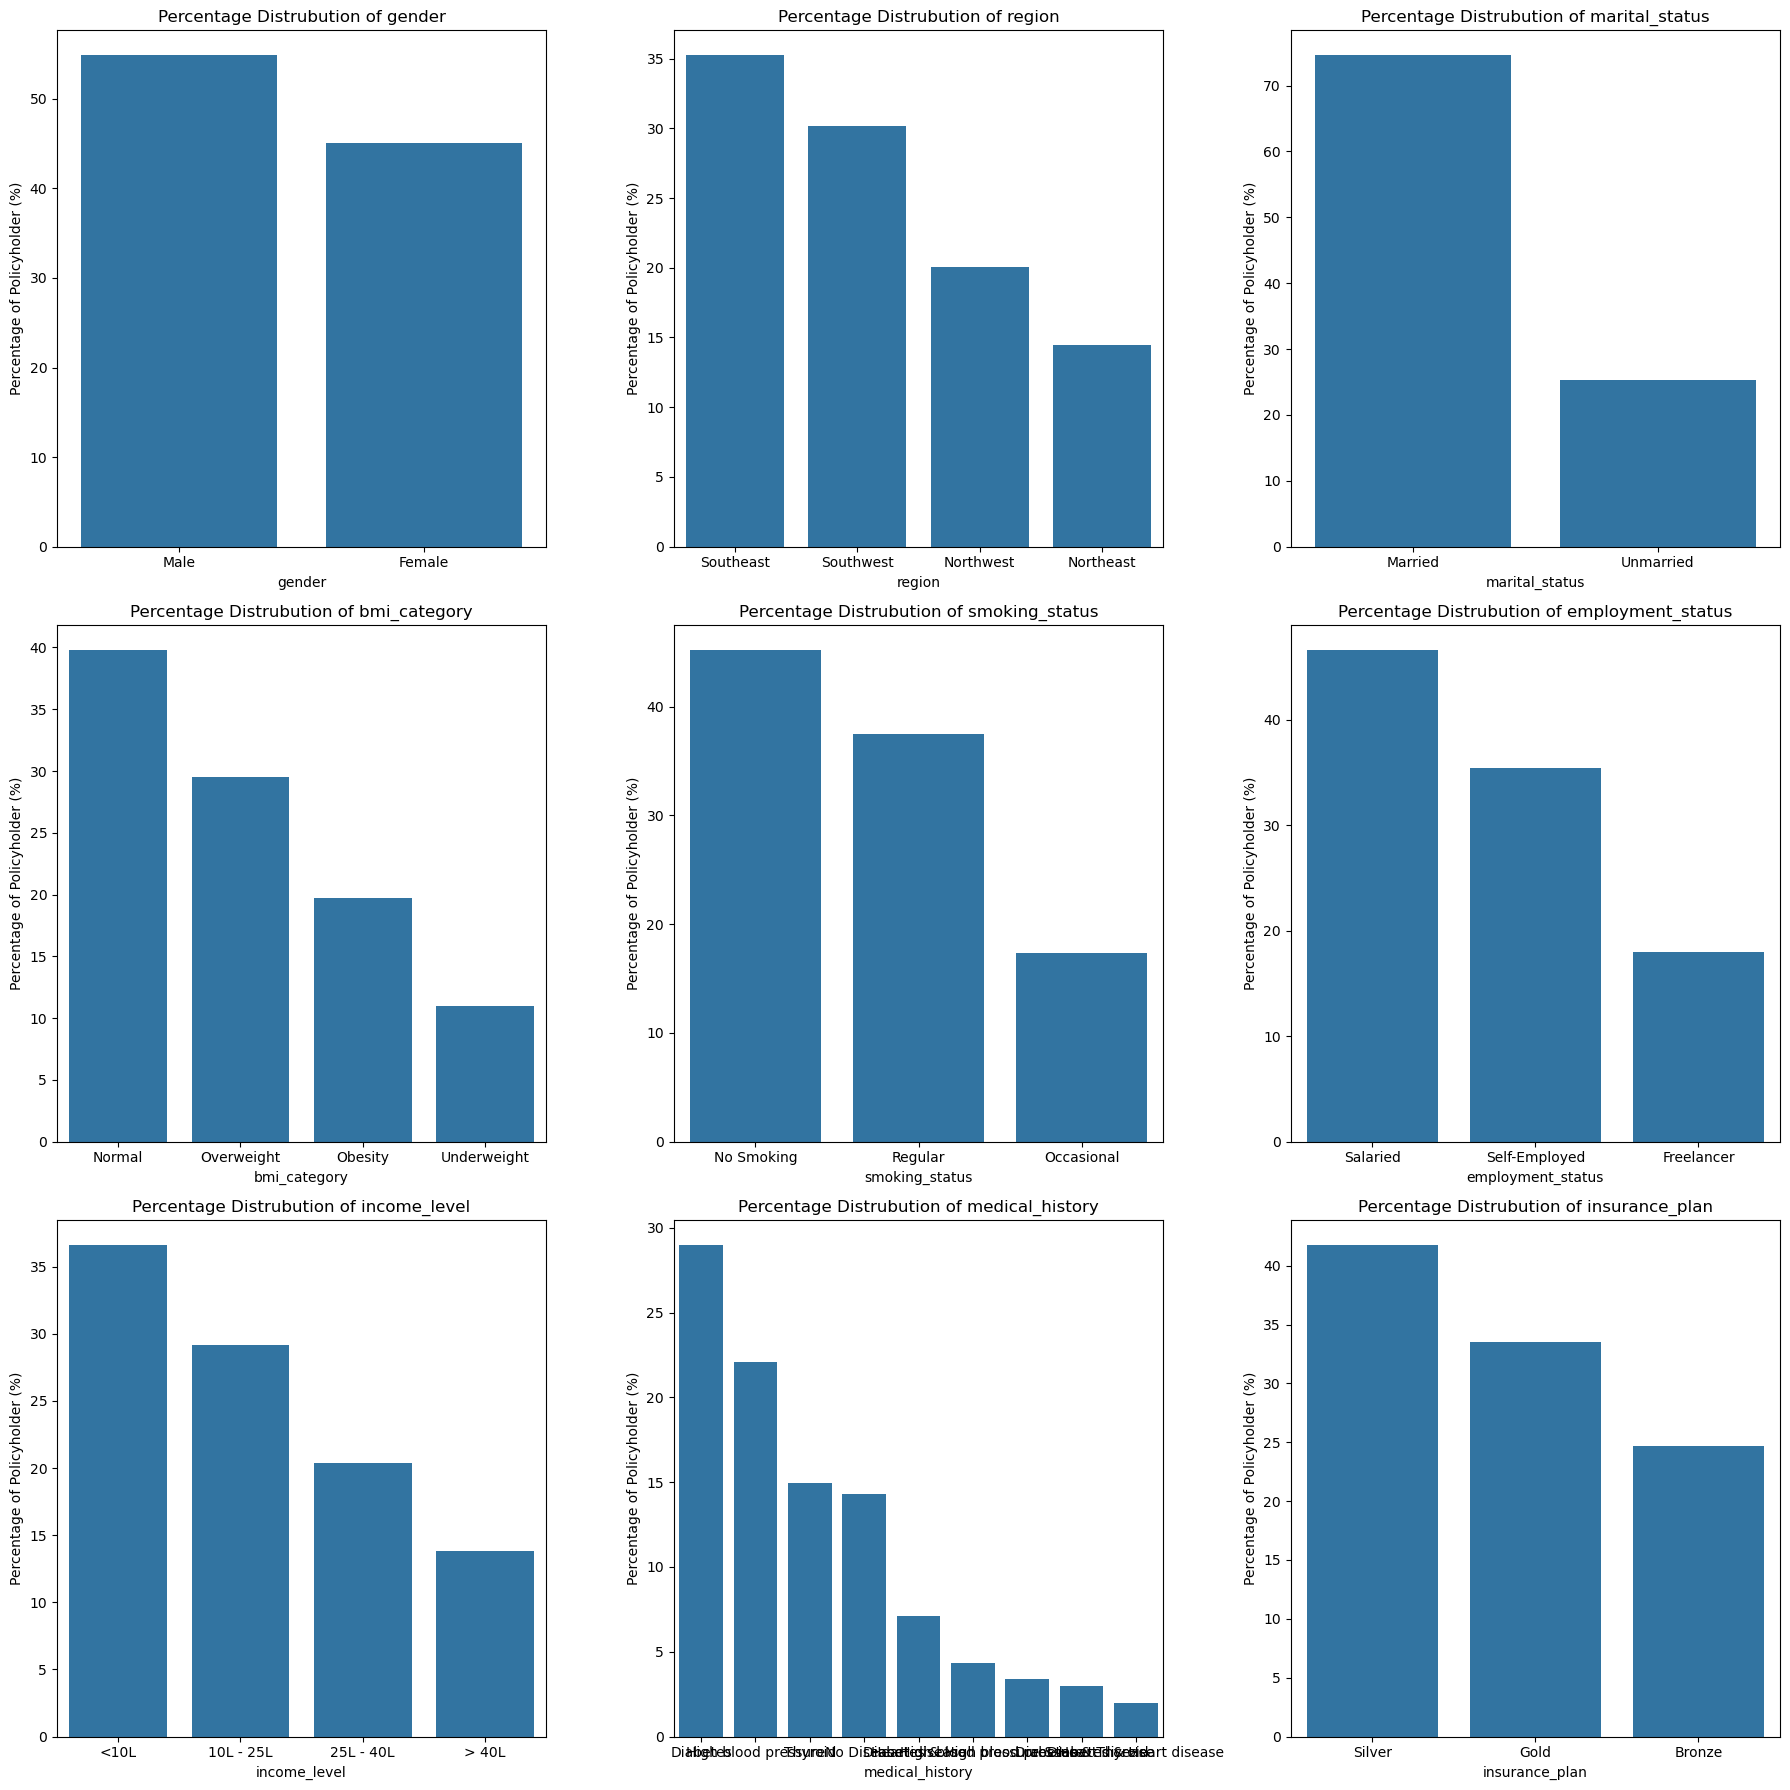

In [79]:
fig, axes = plt.subplots(3,3,figsize=(18,18))
axes = axes.flatten()

for ax, col in zip(axes, categorical_cols):
    categorical_cols = df2[col].value_counts(normalize=True)*100

    sns.barplot(x=categorical_cols.index, y=categorical_cols.values, ax=ax)
    ax.set_title(f'Percentage Distrubution of {col}')
    ax.set_ylabel('Percentage of Policyholder (%)')
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          799  3554    4354
25L - 40L          301  2631    3142
<10L              6054   527    4341
> 40L              214  3287     618


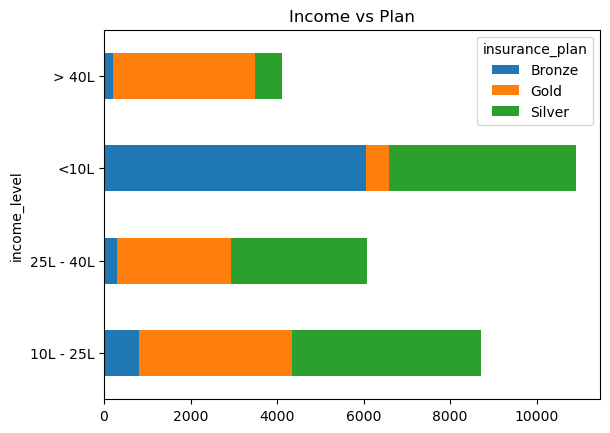

In [80]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)
crosstab.plot(kind='barh', stacked=True)
plt.title('Income vs Plan')
plt.show()

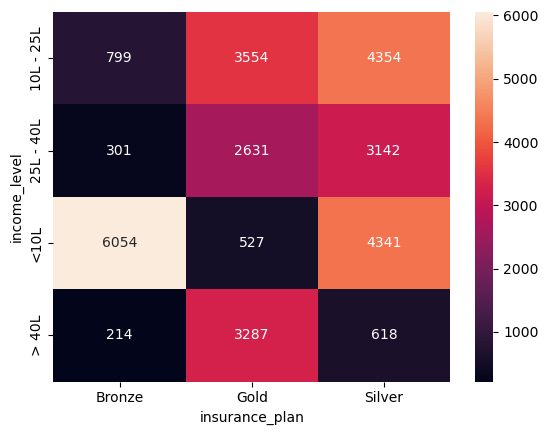

In [81]:
sns.heatmap(crosstab, fmt='d', annot=True)
plt.show()

In [82]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [87]:
risk_scores = {
    "diabetes":6,
    "heart disease":8,
    "high blood pressure":6,
    "thyroid":5,
    "no disease":0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(' & ', expand=True).apply(lambda x:x.str.lower())


In [89]:
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score)/ (max_score - min_score)
df2.sample(10)

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
4759,7955,45,Female,Southwest,Unmarried,0,Underweight,Occasional,Salaried,> 40L,51,No Disease,Gold,21387,no disease,none,0,0.000000
1150,1862,36,Male,Southwest,Unmarried,0,Overweight,Regular,Salaried,25L - 40L,32,No Disease,Silver,19078,no disease,none,0,0.000000
25462,42575,46,Female,Southwest,Married,3,Normal,No Smoking,Self-Employed,> 40L,45,Diabetes,Gold,27000,diabetes,none,6,0.428571
20178,33746,51,Male,Southeast,Unmarried,0,Underweight,Regular,Salaried,10L - 25L,10,High blood pressure,Gold,30196,high blood pressure,none,6,0.428571
8058,13541,54,Male,Northeast,Unmarried,0,Underweight,No Smoking,Self-Employed,> 40L,95,Diabetes,Gold,27390,diabetes,none,6,0.428571
11539,19343,39,Male,Southwest,Married,4,Obesity,Regular,Salaried,25L - 40L,25,No Disease,Silver,20200,no disease,none,0,0.000000
26283,43885,37,Male,Northwest,Married,3,Normal,Regular,Self-Employed,10L - 25L,20,Diabetes,Silver,19076,diabetes,none,6,0.428571
14201,23822,39,Male,Southeast,Unmarried,2,Normal,Regular,Salaried,10L - 25L,19,Thyroid,Gold,24911,thyroid,none,5,0.357143
24131,40422,37,Female,Southwest,Married,2,Overweight,Regular,Freelancer,10L - 25L,24,Diabetes,Silver,20228,diabetes,none,6,0.428571
15870,26575,46,Male,Southeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,17,High blood pressure & Heart disease,Gold,35545,high blood pressure,heart disease,14,1.000000


In [91]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

In [93]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [95]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head()

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0,26,0,1,6,Diabetes,1,9053,diabetes,none,...,0,0,1,0,0,0,0,0,1,0
1,1,29,2,1,6,Diabetes,1,16339,diabetes,none,...,1,0,0,1,0,0,0,1,1,0
2,2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,...,0,0,0,0,0,0,0,0,0,1
3,3,30,3,4,77,No Disease,3,20303,no disease,none,...,1,0,0,0,0,0,0,0,1,0
4,5,56,3,2,14,Diabetes,1,15610,diabetes,none,...,0,0,0,1,0,0,1,0,0,1


In [97]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


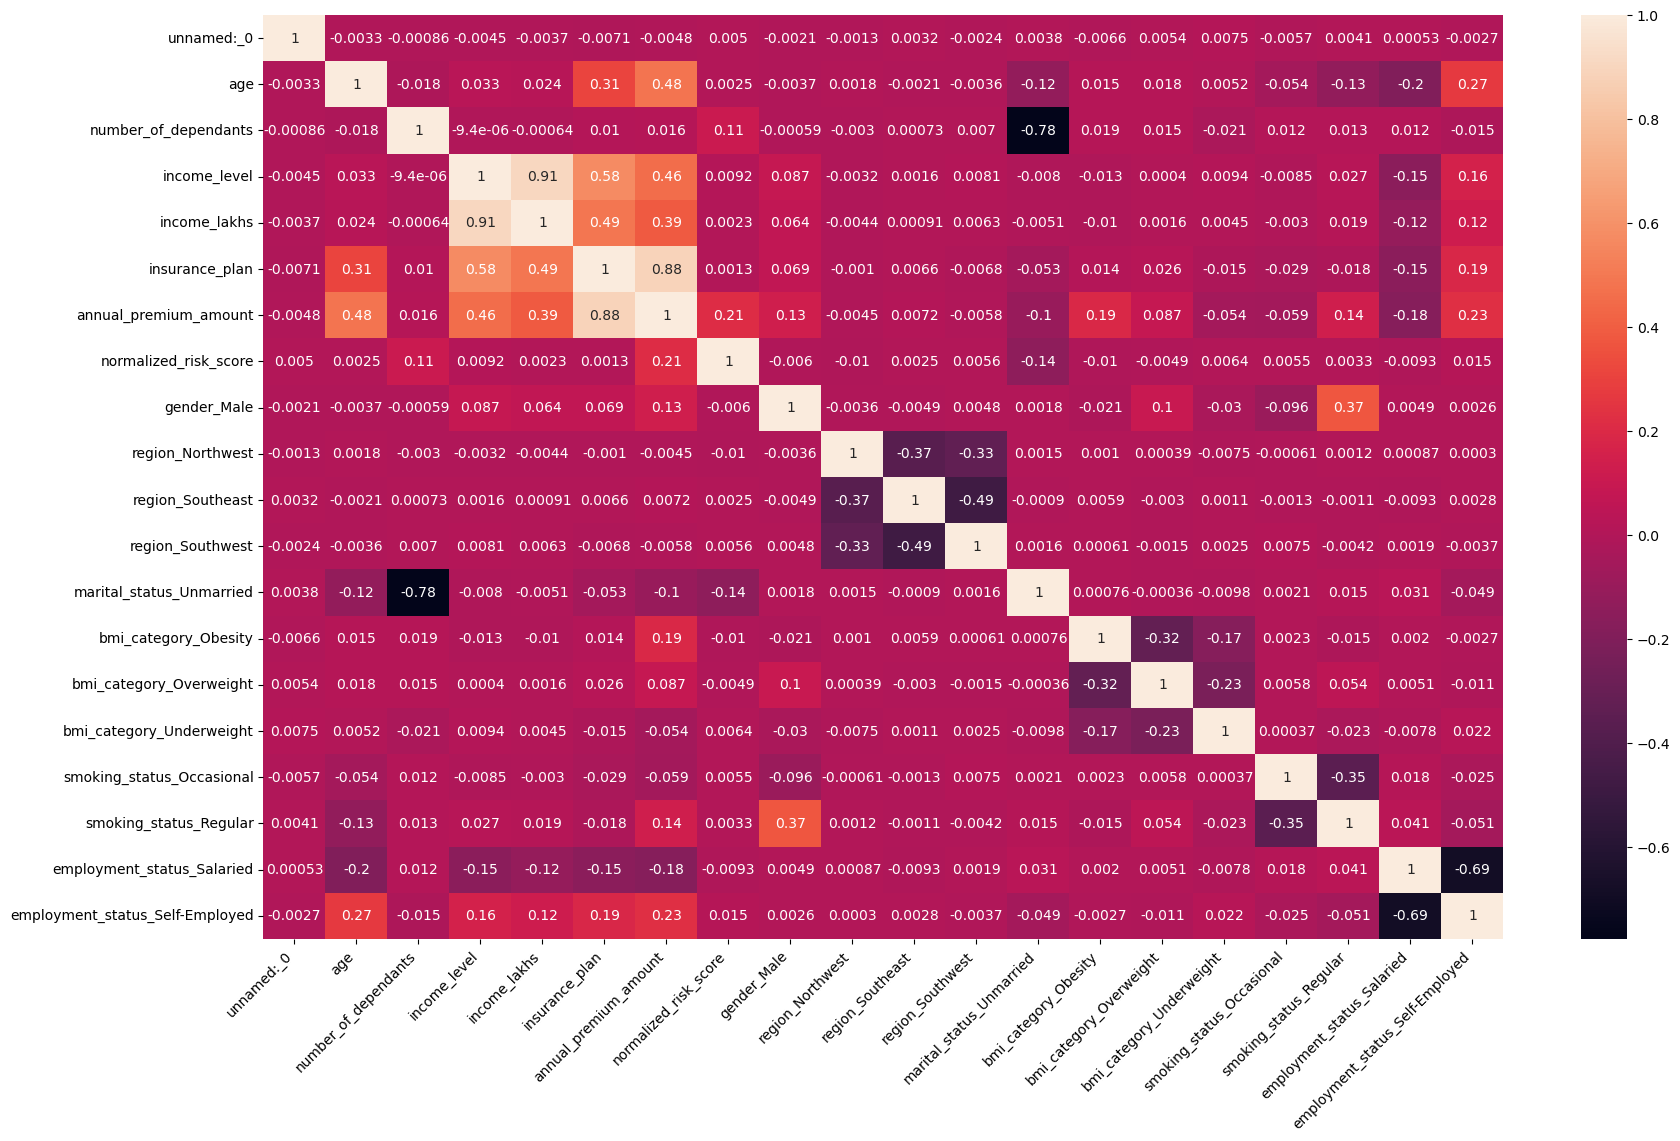

In [99]:
cm = df4.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.show()

In [100]:
df4.head(2)

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


In [101]:
X = df4.drop('annual_premium_amount', axis=1)
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0,0.000000,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,1,0.065217,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,2,0.500000,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,3,0.086957,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,5,0.652174,0.6,0.333333,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


In [102]:
X.shape

(29822, 19)

In [107]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [109]:
calculate_vif(X)

,Column,VIF
0,unnamed:_0,3.708010
1,age,3.957380
2,number_of_dependants,6.574054
3,income_level,13.890759
4,income_lakhs,11.186315
5,insurance_plan,5.272795
6,normalized_risk_score,3.847203
7,gender_Male,2.600903
8,region_Northwest,2.143527
9,region_Southeast,3.016241


In [110]:
calculate_vif(X.drop("income_level" ,axis=1))

,Column,VIF
0,unnamed:_0,3.707947
1,age,3.898275
2,number_of_dependants,6.573384
3,income_lakhs,2.679612
4,insurance_plan,4.576402
5,normalized_risk_score,3.845003
6,gender_Male,2.593274
7,region_Northwest,2.142869
8,region_Southeast,3.015344
9,region_Southwest,2.736554


In [111]:
X_reduced = X.drop('income_level', axis=1)
X_reduced.head()

,unnamed:_0,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0,0.000000,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,1,0.065217,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,2,0.500000,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,3,0.086957,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,5,0.652174,0.6,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


### Model Train

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

print("x train: ", X_train.shape)
print("x test: ", X_test.shape)
print("y train: ", y_train.shape)
print("y test: ", y_test.shape)

x train:  (20875, 18)
x test:  (8947, 18)
y train:  (20875,)
y test:  (8947,)


In [115]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
test_score, train_score

(0.953841128576026, 0.9534184332289006)

In [116]:
feature_importances = model_lr.coef_
pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])

,Coefficients
unnamed:_0,0.000688
age,7016.330816
number_of_dependants,-1312.055895
income_lakhs,-708.042262
insurance_plan,14836.175303
normalized_risk_score,6053.658068
gender_Male,37.645174
region_Northwest,-55.338293
region_Southeast,-19.813028
region_Southwest,-22.280924


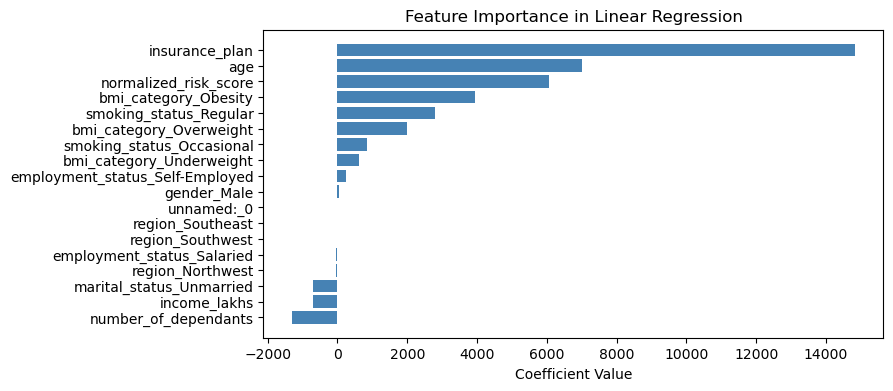

In [117]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [123]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.9534182674866951, 0.9538420204822269)

In [124]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9979413523998375

In [126]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.9970309408868041

In [128]:
best_model = random_search.best_estimator_

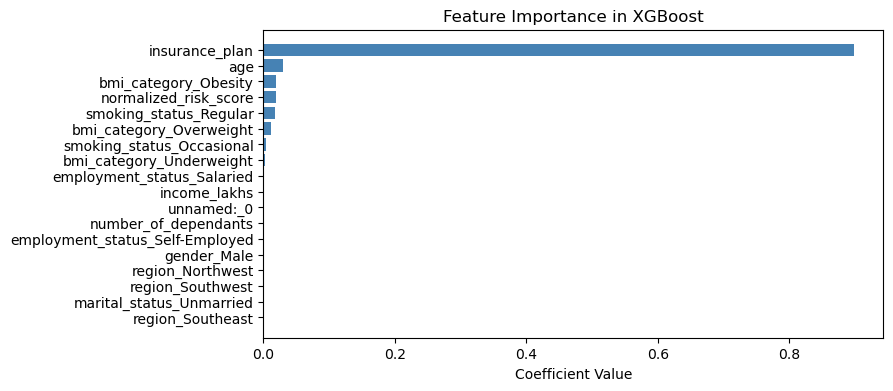

In [129]:
feature_importance = best_model.feature_importances_
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

In [131]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
rediduals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': rediduals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
19713,26895,26691.470703,-203.529297,-0.756755
14750,22734,22650.759766,-83.240234,-0.366149
19932,21198,21581.896484,383.896484,1.811003
29643,9100,9425.934570,325.934570,3.581699
17076,26434,26691.470703,257.470703,0.974013


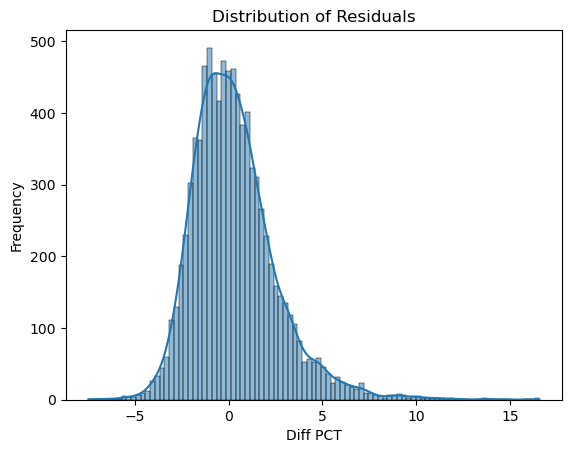

In [132]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.title("Distribution of Residuals")
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [133]:
X_test.shape

(8947, 18)

In [134]:
extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df

,actual,predicted,diff,diff_pct
14286,6845,7621.264648,776.264648,11.340608
27518,8502,9425.934570,923.934570,10.867261
9285,6872,7621.264648,749.264648,10.903153
7547,6538,7621.264648,1083.264648,16.568747
21910,6651,7621.264648,970.264648,14.588252
12189,6571,7621.264648,1050.264648,15.983331
21141,10722,11841.493164,1119.493164,10.441085
16263,8206,9063.518555,857.518555,10.449897
8216,6635,7621.264648,986.264648,14.864576
13973,10583,11841.493164,1258.493164,11.891649


In [135]:
extreme_errors_pct = extreme_results_df.shape[0] * 100/ X_test.shape[0]

In [136]:
extreme_errors_pct

0.32413099362914943

In [137]:
extreme_results_df[abs(extreme_results_df.diff_pct)>50].sort_values("diff_pct", ascending=False)

,actual,predicted,diff,diff_pct


In [138]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,unnamed:_0,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14286,23963,0.021739,0.6,0.050505,0.0,0.000000,1,1,0,0,1,0,0,0,0,0,1,0
27518,45953,0.304348,0.6,0.080808,0.0,0.357143,1,1,0,0,0,0,0,0,0,0,0,1


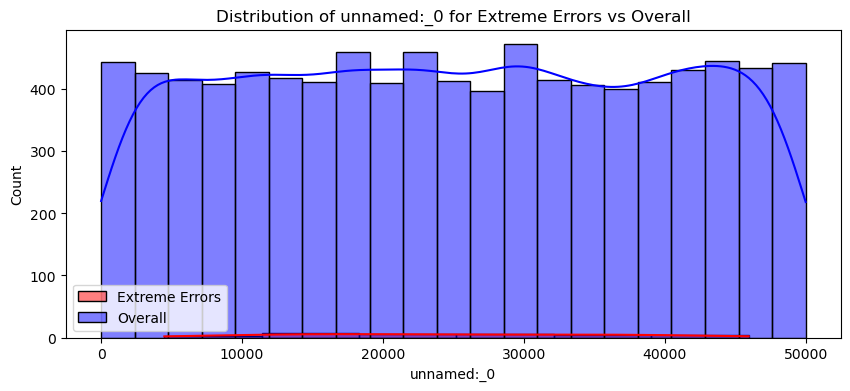

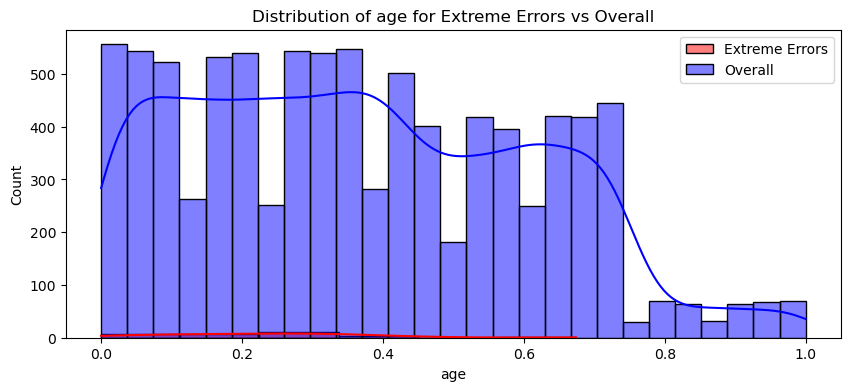

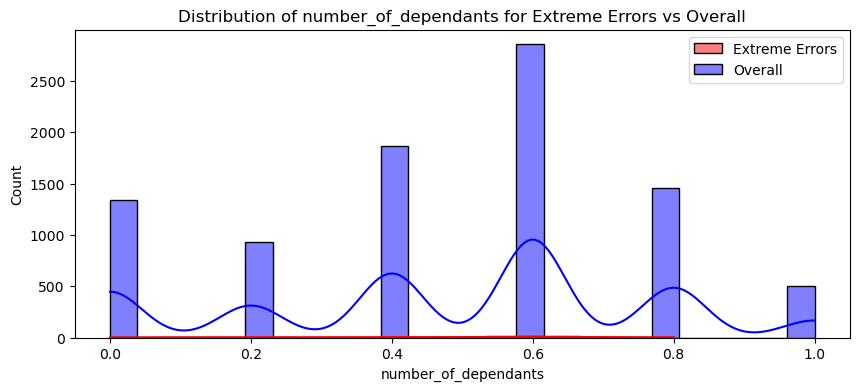

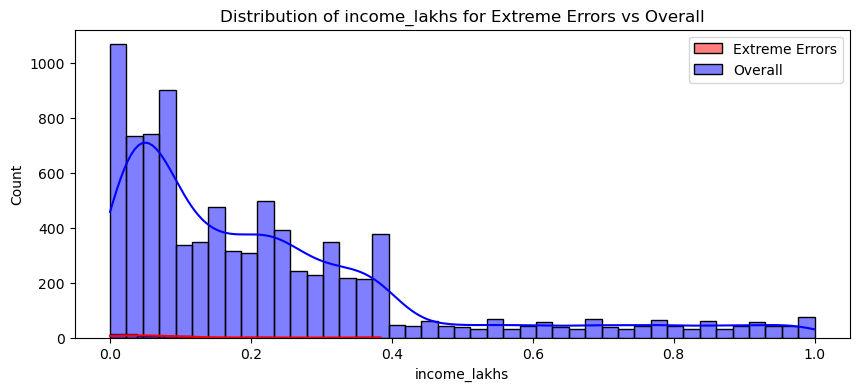

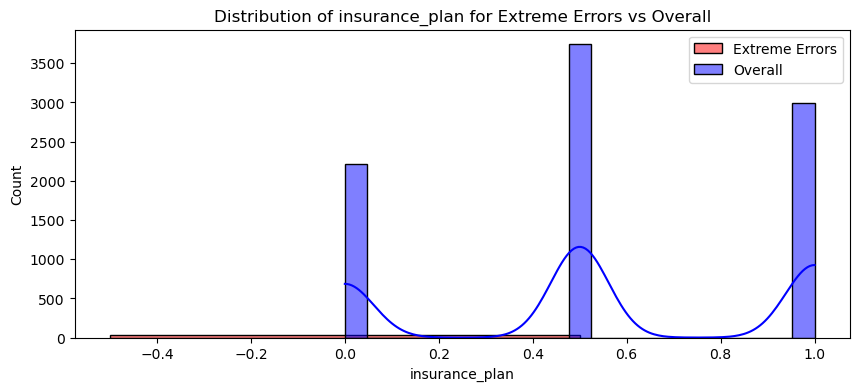

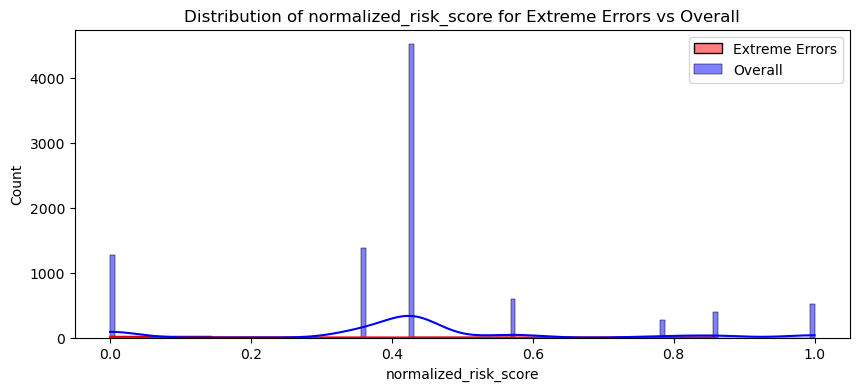

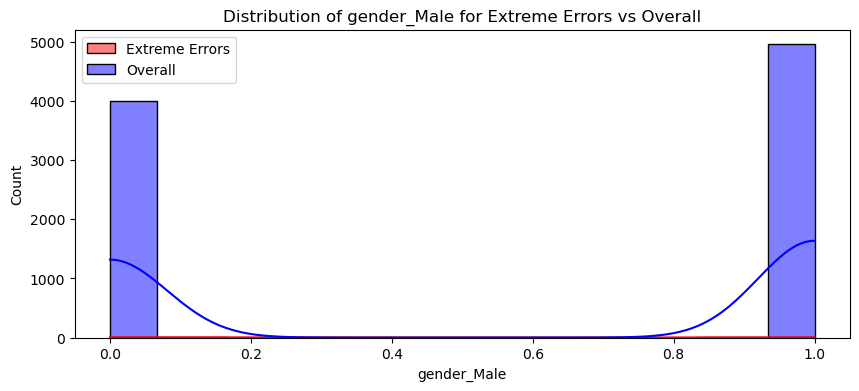

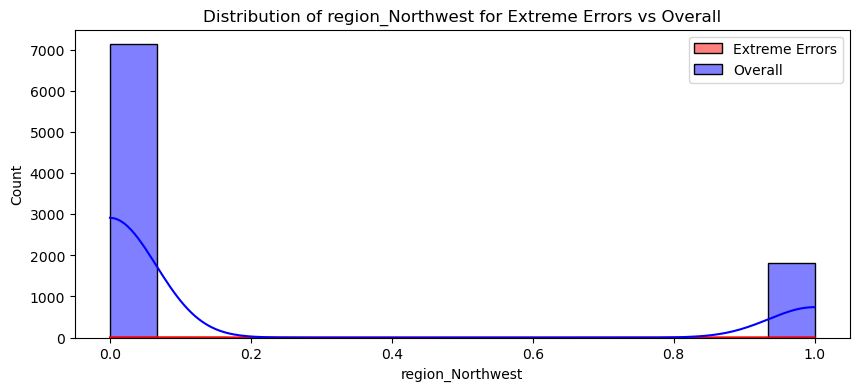

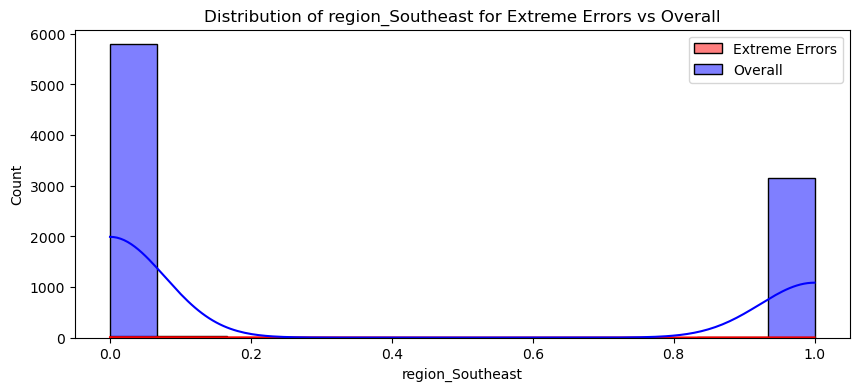

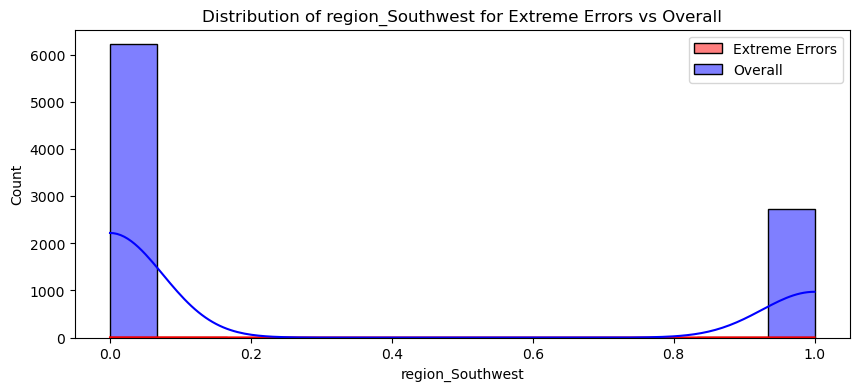

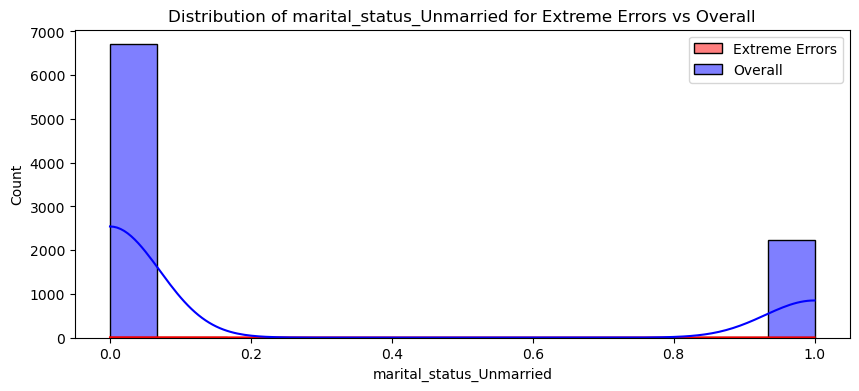

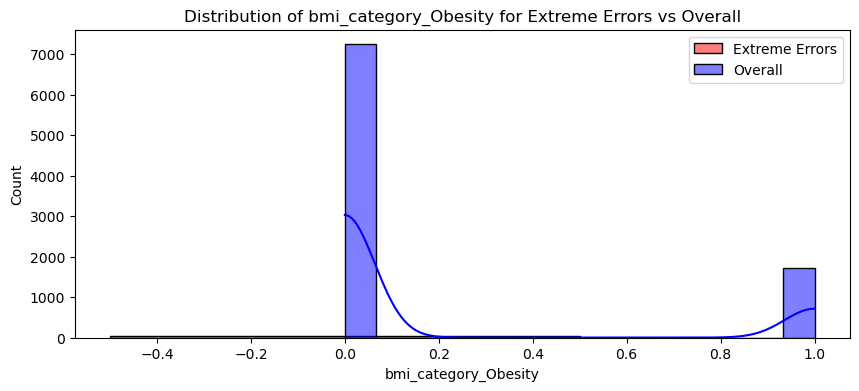

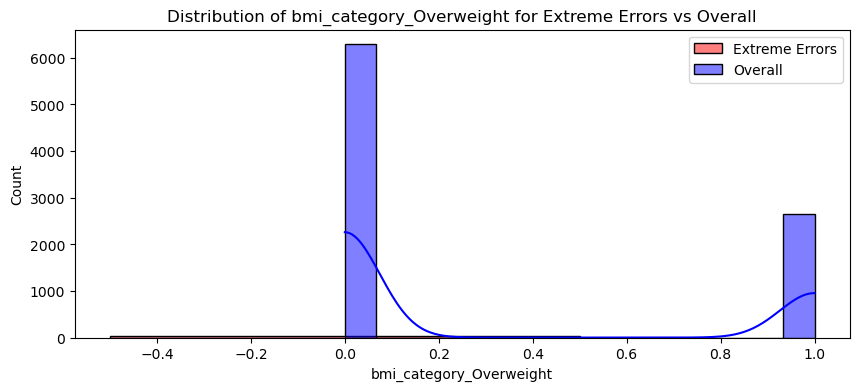

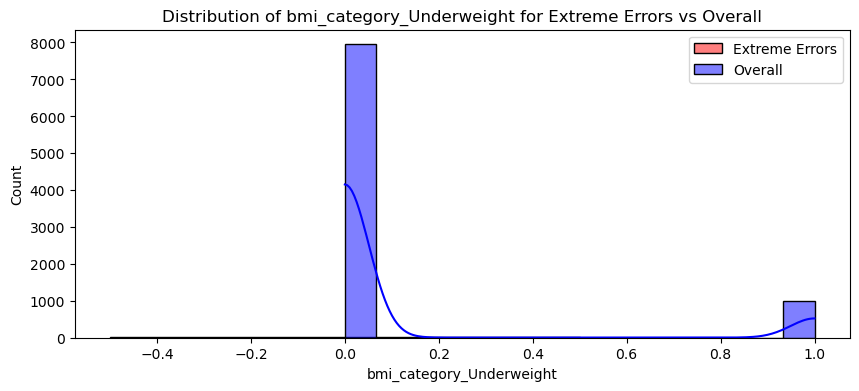

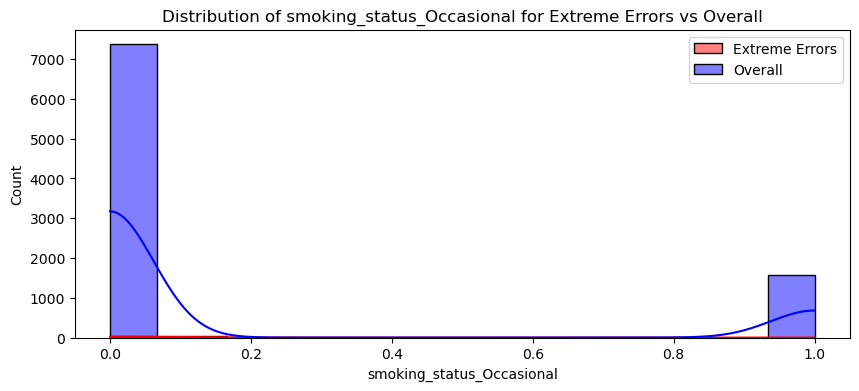

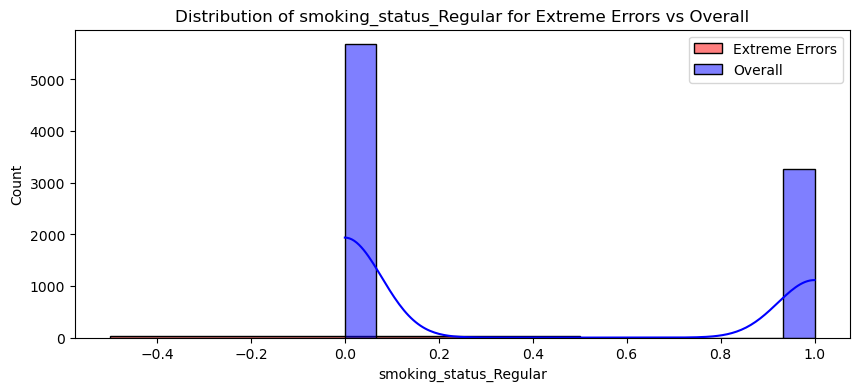

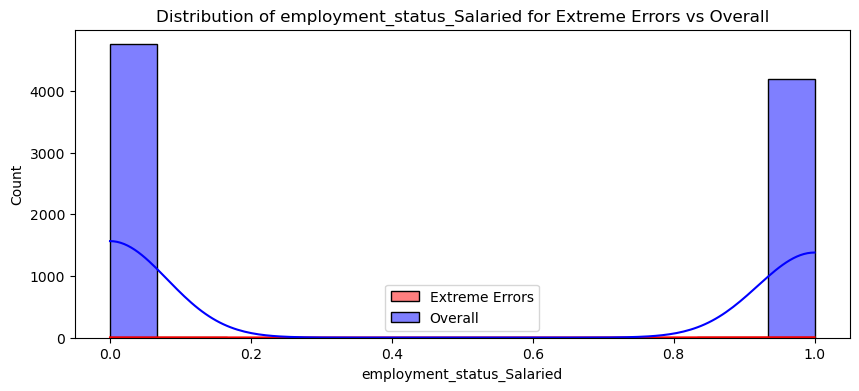

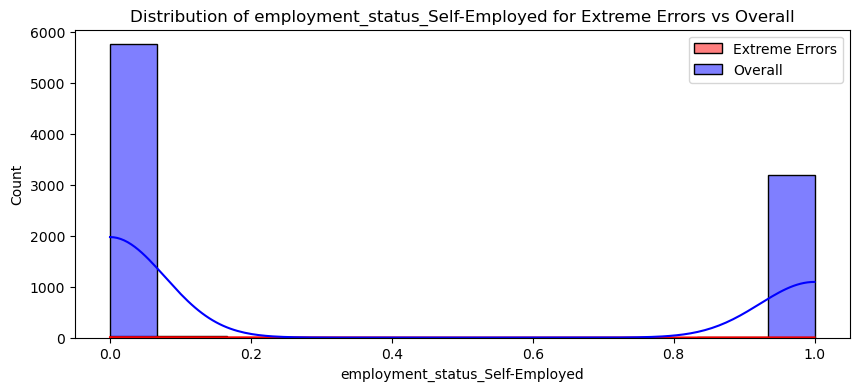

In [139]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

In [140]:
extreme_errors_df['income_level']=-1

In [141]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,27.0,3.0,-2.0,6.0,1.0
1,40.0,3.0,-2.0,9.0,1.0
2,41.0,3.0,-2.0,2.0,1.0
3,42.0,1.0,-2.0,9.0,1.0
4,28.0,3.0,-2.0,3.0,1.0


In [142]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,29.000000,29.000000,29.0,29.000000,29.0
mean,36.586207,2.241379,-2.0,6.862069,1.0
std,6.811321,1.184880,0.0,7.619168,0.0
min,26.000000,0.000000,-2.0,1.000000,1.0
25%,32.000000,1.000000,-2.0,3.000000,1.0
50%,37.000000,3.000000,-2.0,5.000000,1.0
75%,40.000000,3.000000,-2.0,9.000000,1.0
max,57.000000,4.000000,-2.0,39.000000,1.0


<Axes: xlabel='age', ylabel='Count'>

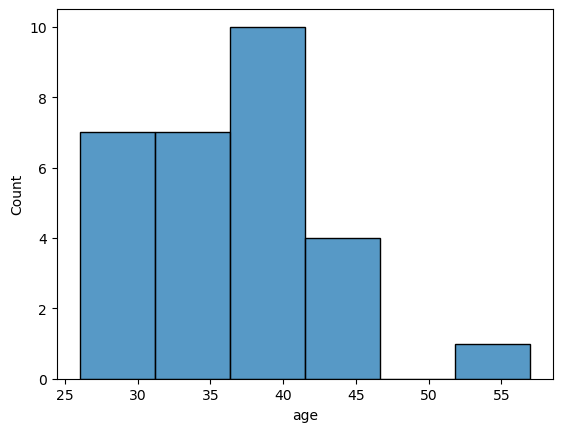

In [143]:
sns.histplot(df_reversed.age)